In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
# Claudio Iturra, 2025

In [2]:
data = loadmat("/home/cl/Dropbox/Codes/python/current/20041226_20050128.mat")

In [3]:
speedS = data['SerMagmmpersec'][227:1514,:]
dirS = data['SerDir10thDeg'][227:1514,:]
vS = data['SerNmmpersec'][227:1514,:]
uS = data['SerEmmpersec'][227:1514,:]
wS = data['SerVmmpersec'][227:1514,:]
ea1 = data['SerEA1cnt'][227:1514,:]
ea2 = data['SerEA1cnt'][227:1514,:]
ea3 = data['SerEA1cnt'][227:1514,:]
ea4 = data['SerEA1cnt'][227:1514,:]
eaa = data['SerEAAcnt'][227:1514,:]

tempS = data['AnT100thDeg'][227:1514]
presS = data['AnDepthmm'][227:1514]
tempS =tempS.flatten()
presS =presS.flatten()

speedS = speedS.astype(np.float32)  # or np.float64
dirS = dirS.astype(np.float32)  # or np.float64
uS = uS.astype(np.float32)  # or np.float64
vS = vS.astype(np.float32)  # or np.float64
wS = wS.astype(np.float32)  # or np.float64
ea1 = ea1.astype(np.float32)  # or np.float64
ea2 = ea2.astype(np.float32)  # or np.float64
ea3 = ea3.astype(np.float32)  # or np.float64
ea4 = ea4.astype(np.float32)  # or np.float64
eaa = eaa.astype(np.float32)  # or np.float64

dirS[speedS < 0] = np.nan
uS[speedS < 0] = np.nan
vS[speedS < 0] = np.nan
wS[speedS < 0] = np.nan
speedS[speedS < 0] = np.nan

In [4]:
y = data['SerYear'][227:1514].astype(np.float32) + 2000
m = data['SerMon'][227:1514]
d = data['SerDay'][227:1514]
h = data['SerHour'][227:1514]
ms = data['SerMin'][227:1514]
s = data['SerSec'][227:1514]

In [5]:
y = y.reshape(1287)
m = m.reshape(1287)
d = d.reshape(1287)
h = h.reshape(1287)
ms = ms.reshape(1287)
s = s.reshape(1287)

In [6]:
timeX = pd.DataFrame({'year': y,
                     'month': m,
                     'day': d,
                     'hour': h,
                     'minute': ms,
                     'second': s})

timeX['datetime'] = pd.to_datetime(timeX[['year', 'month', 'day', 'hour', 'minute', 'second']])

In [7]:
timeX['datetime']

0      2004-12-30 17:30:00
1      2004-12-30 18:00:00
2      2004-12-30 18:30:00
3      2004-12-30 19:00:00
4      2004-12-30 19:30:00
               ...        
1282   2005-01-26 10:30:00
1283   2005-01-26 11:00:00
1284   2005-01-26 11:30:00
1285   2005-01-26 12:00:00
1286   2005-01-26 12:30:00
Name: datetime, Length: 1287, dtype: datetime64[ns]

In [8]:
z = np.nanmean(data['AnDepthmm'])
mid = 6
start = 98 - mid  # 95
end = 0
step = -4
depth = list(range(start, end - 1, step))
len(depth)
del mid, start, end, z
depth

[92,
 88,
 84,
 80,
 76,
 72,
 68,
 64,
 60,
 56,
 52,
 48,
 44,
 40,
 36,
 32,
 28,
 24,
 20,
 16,
 12,
 8,
 4,
 0]

In [9]:
from multitaper import MTSpec

In [10]:
uS.shape

(1287, 27)

In [11]:
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
from multitaper import MTSpec  #using German Prieto's multitaper package, https://github.com/gaprieto/multitaper
from scipy import fft as spfft
from scipy.fft import fft 
from scipy.stats import chi2
from scipy.special import digamma

In [12]:
import spectrum
import analytic_wavelet
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
import time

Text(0.5, 1.0, 'Negative Freq')

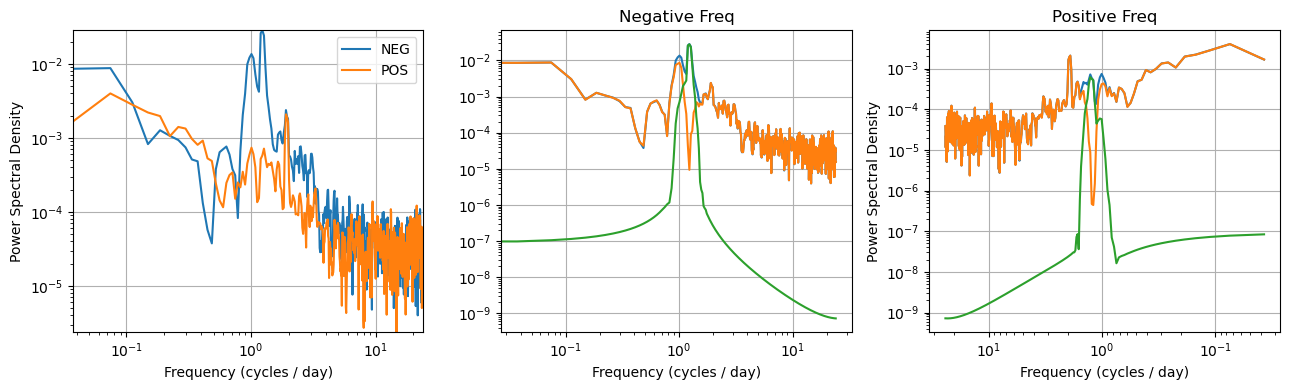

In [13]:
x = pd.Series(uS[:,19], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,19], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000
cv_centered = cv - np.mean(cv)
f, p = signal.periodogram(cv_centered, fs=1/dt, return_onesided=False, axis=0)

NW = 2
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv_centered))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
p = np.mean(Sk*eigenvalues, axis=1) * dt

plt.figure(figsize=(13, 4))
plt.subplot(1,3,1)
plt.loglog(f[f >= 0], p[np.where(f >= 0)])
plt.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
plt.autoscale(enable=True, tight=True)
plt.tight_layout(), plt.grid()
plt.xlabel("Frequency (cycles / day)")
plt.ylabel("Power Spectral Density")
plt.legend(['NEG','POS'])
plt.tight_layout()

#---------------------------------------------

gamma = 3
beta = 30
omega=2*np.pi*33/len(cv_centered)

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv_centered), omega)

#compute two bandpassed signals, one for the negative side and one for the positive side
cvo_K1NIOSneg = analytic_wavelet.analytic_wavelet_transform(cv_centered, psif, False).flatten() #NEGATIVE BAND
cvo_K1NIOSpos = np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv_centered), psif, False)).flatten() #POSITIVE BAND
cvo_K1NIOS = 1/np.sqrt(2)*(cvo_K1NIOSneg + cvo_K1NIOSpos)
cvr_K1NIOS = cvo_K1NIOS  - cv_centered

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo_K1NIOS, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo_K1NIOS))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * dt

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr_K1NIOS, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr_K1NIOS))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * dt

plt.subplot(1,3,3)
plt.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
plt.loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
plt.loglog(np.abs(f[f < 0]), po[np.where(f < 0)])
plt.xlabel("Frequency (cycles / day)")
plt.ylabel("Power Spectral Density")
plt.title('Positive Freq')
plt.tight_layout()
plt.gca().invert_xaxis(), plt.grid()

plt.subplot(1,3,2)
plt.loglog(f[f >= 0], p[np.where(f >= 0)])
plt.loglog(f[f >= 0], pr[np.where(f >= 0)])
plt.loglog(f[f >= 0], po[np.where(f >= 0)])
plt.tight_layout(), plt.grid()
plt.xlabel("Frequency (cycles / day)")
plt.title('Negative Freq')

In [14]:
#xfix = np.full((1287, 21), np.nan)
#yfix = np.full((1287, 21), np.nan)
#
#for i in range(0, 21):
#    x = pd.Series(uS[:,i], index=timeX['datetime'])
#    x = x.interpolate(method="time")
#    x = x.values
#
#    y = pd.Series(vS[:,i], index=timeX['datetime'])
#    y = y.interpolate(method="time")
#    y = y.values
#
#    xfix[:,i] = x
#    yfix[:,i] = y
#    del x, y

In [15]:
from pandas import date_range
timeX['datetime'][0]

N = len(timeX['datetime'])
t = date_range(start="2004-12-30 17:30:00", periods=N, freq="30min")
t

DatetimeIndex(['2004-12-30 17:30:00', '2004-12-30 18:00:00',
               '2004-12-30 18:30:00', '2004-12-30 19:00:00',
               '2004-12-30 19:30:00', '2004-12-30 20:00:00',
               '2004-12-30 20:30:00', '2004-12-30 21:00:00',
               '2004-12-30 21:30:00', '2004-12-30 22:00:00',
               ...
               '2005-01-26 08:00:00', '2005-01-26 08:30:00',
               '2005-01-26 09:00:00', '2005-01-26 09:30:00',
               '2005-01-26 10:00:00', '2005-01-26 10:30:00',
               '2005-01-26 11:00:00', '2005-01-26 11:30:00',
               '2005-01-26 12:00:00', '2005-01-26 12:30:00'],
              dtype='datetime64[ns]', length=1287, freq='30min')

In [16]:
from utide import solve, reconstruct

utidal = np.full((len(t), 21), np.nan);
vtidal = np.full((len(t), 21), np.nan);
uSfix = np.full((len(t), 21), np.nan);
vSfix = np.full((len(t), 21), np.nan);

for i in range(0,21):
    zu = pd.Series(uS[:,i], index=timeX['datetime'])
    zu = zu.interpolate(method="time")
    zu = zu.values
    uSfix[:,i] = zu
    zv = pd.Series(vS[:,i], index=timeX['datetime'])
    zv = zv.interpolate(method="time")
    zv = zv.values
    vSfix[:,i] = zv
    
    coef = solve(
        t, zu/1000, zv/1000,
        lat=-36,
        nodal=False,
        trend=False,
        method='ols',
        conf_int='linear',
        Rayleigh_min=0.95,
    );
    
    tide = reconstruct(t, coef);
    utidal[:,i] = tide['u'];
    vtidal[:,i] = tide['v'];
    
    del coef, tide

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
done.: matrix prep ... solution ... 
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... don

In [17]:
u_baroclinic = uSfix/1000 - utidal
v_baroclinic = vSfix/1000 - vtidal

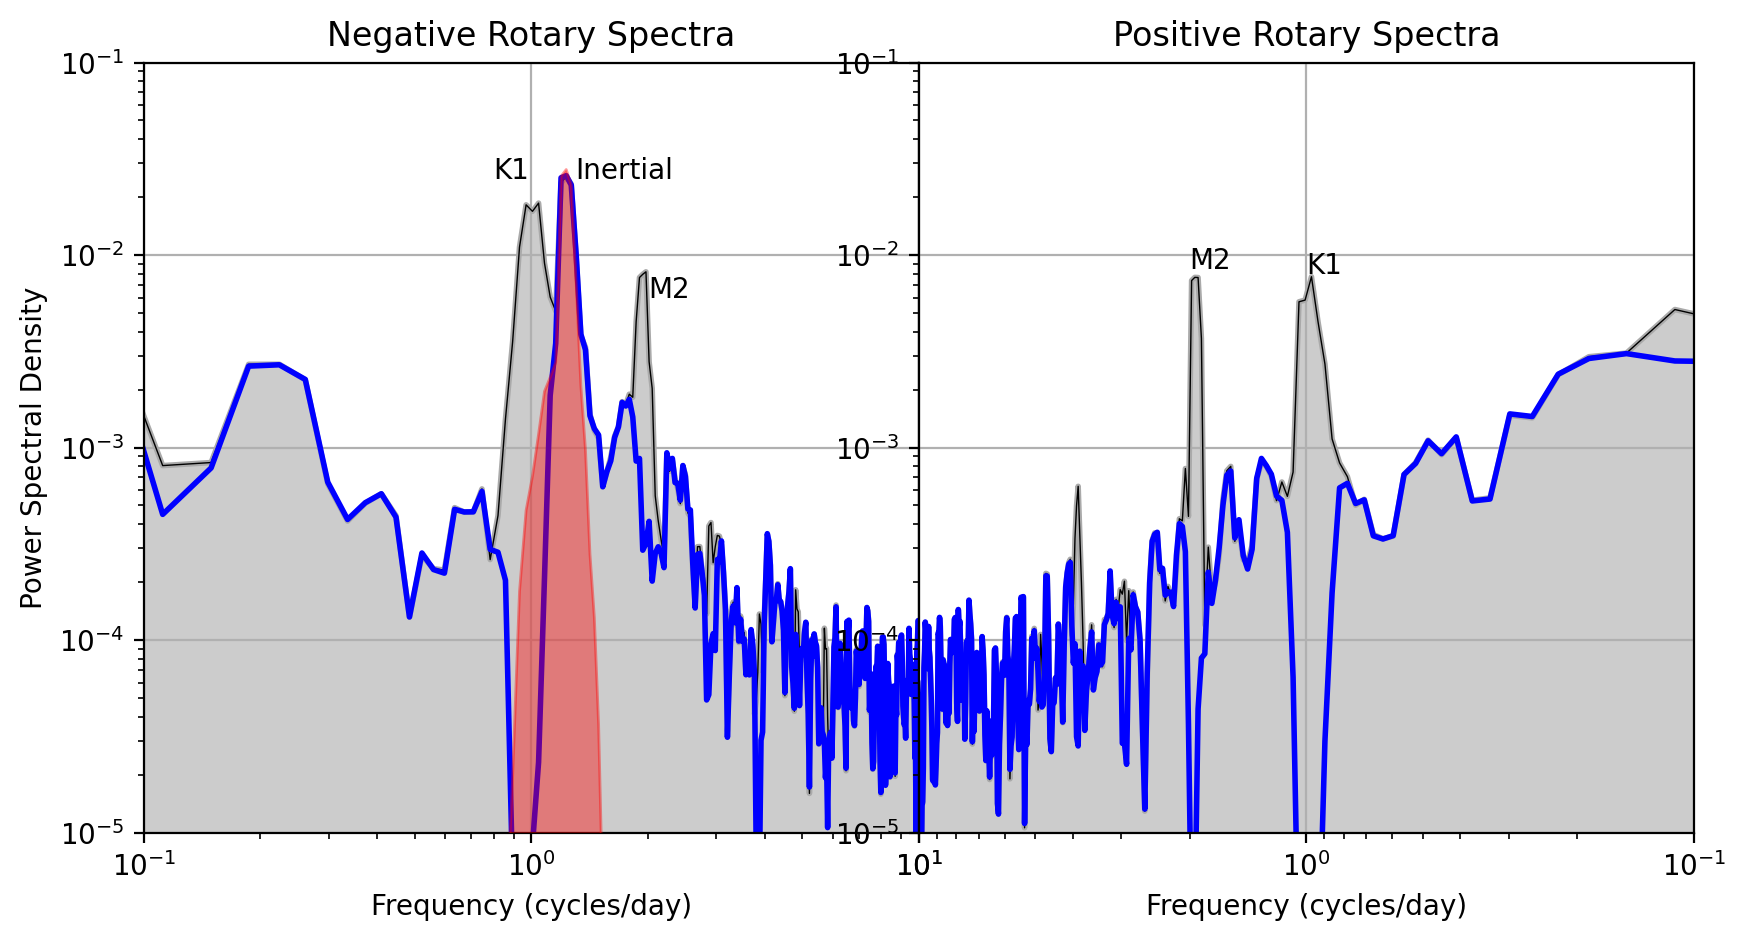

In [18]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 200
pyplot.rcParams['savefig.dpi'] = 200

x = pd.Series(uS[:,20], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,20], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000 
P = 2
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
So = np.ravel(spec.spec)
fo = np.ravel(spec.freq)

cv = u_baroclinic[:,20] +1j*v_baroclinic[:,20]
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
Sox = np.ravel(spec.spec)
fox = np.ravel(spec.freq)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
mask = fo >= 0
plt.fill_between(fo[mask], So[mask], color="grey", alpha=0.4)
plt.loglog(fo[fo>0],So[fo>0],linewidth=2,color="#AAAAAA")#plot positive side
plt.loglog(fo[fo>0],So[fo>0],linewidth=0.5,color="k")#plot positive side
mask = f >= 0
#plt.loglog(f[f >= 0], po[np.where(f >= 0)],linewidth=1,color="r")
#plt.fill_between(f[mask], po[mask], color="grey", alpha=0.4)
plt.loglog(fox[fox>0],Sox[fox>0],linewidth=2,color="blue")#plot positive side
plt.fill_between(f[mask], po[mask], color="red", alpha=0.4, zorder=3)
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power Spectral Density')
plt.title('Negative Rotary Spectra');
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.text(1.3,0.025,'Inertial')
plt.text(0.8,0.025,'K1')
plt.text(2,0.006,'M2')
plt.grid()

#x_start, y_start = 10e0, 10e-6   # same as 10e-1
#x_end, y_end     = 10e-2, 10e-2  # same as 10e-10 and 10e-5
#plt.plot([x_start, x_end], [y_start, y_end], 'r', linewidth=1)
plt.gca().invert_xaxis()


plt.subplot(1,3,2)
mask = fo<0
plt.fill_between(-fo[mask], So[mask], color="grey", alpha=0.4)
plt.loglog(-fo[fo<0],So[fo<0],linewidth=2,color="#AAAAAA")#plot negative side
plt.loglog(-fo[fo<0],So[fo<0],linewidth=0.5,color="k")#plot negative side
plt.loglog(-fox[fox<0],Sox[fox<0],linewidth=2,color="b")#plot negative side
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Frequency (cycles/day)')
plt.title('Positive Rotary Spectra');
plt.text(1,0.008,'K1')
plt.text(2,0.0085,'M2')
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.grid()

#x_start, y_start = 10e0, 10e-6   # same as 10e-1
#x_end, y_end     = 10e-2, 10e-2  # same as 10e-10 and 10e-5
#plt.plot([x_start, x_end], [y_start, y_end], 'r', linewidth=1)


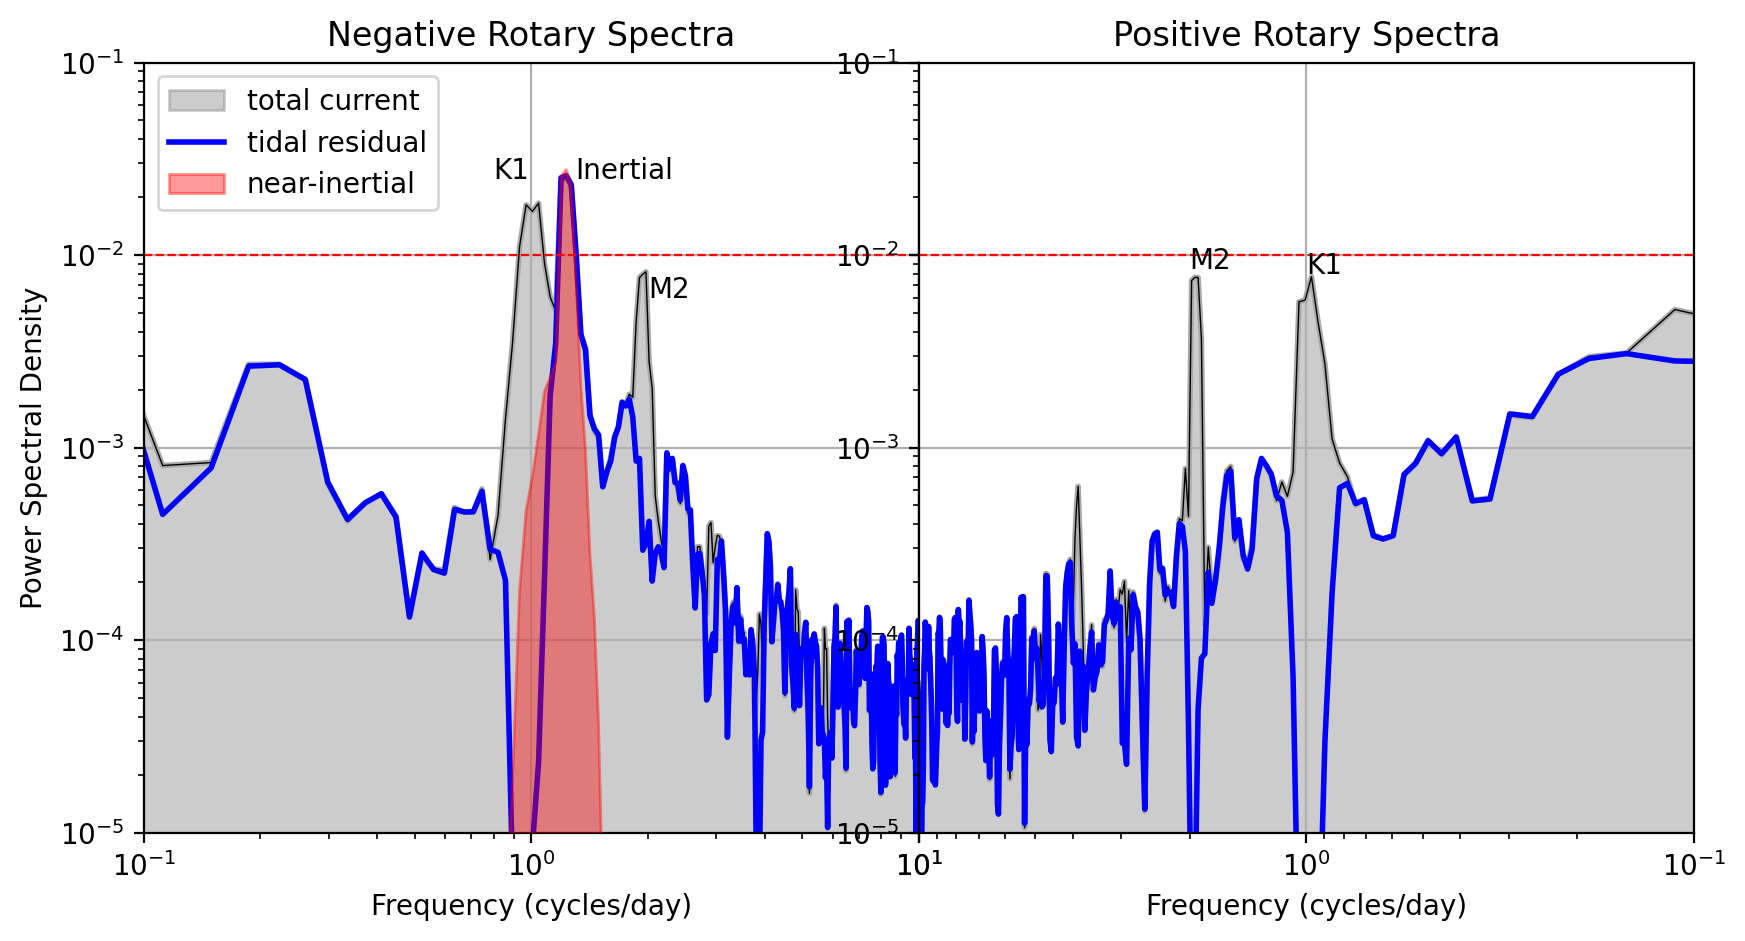

In [19]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 200
pyplot.rcParams['savefig.dpi'] = 200

x = pd.Series(uS[:,20], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,20], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000 
P = 2
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
So = np.ravel(spec.spec)
fo = np.ravel(spec.freq)

cv = u_baroclinic[:,20] +1j*v_baroclinic[:,20]
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
Sox = np.ravel(spec.spec)
fox = np.ravel(spec.freq)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
mask = fo >= 0
plt.fill_between(fo[mask], So[mask], color="grey", alpha=0.4, label = 'total current')
plt.loglog(fo[fo>0],So[fo>0],linewidth=2,color="#AAAAAA")#plot positive side
plt.loglog(fo[fo>0],So[fo>0],linewidth=0.5,color="k")#plot positive side
mask = f >= 0
#plt.loglog(f[f >= 0], po[np.where(f >= 0)],linewidth=1,color="r")
#plt.fill_between(f[mask], po[mask], color="grey", alpha=0.4)
plt.loglog(fox[fox>0],Sox[fox>0],linewidth=2,color="blue", label = 'tidal residual')#plot positive side
plt.fill_between(f[mask], po[mask], color="red", alpha=0.4, zorder=3, label = 'near-inertial')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power Spectral Density')
plt.title('Negative Rotary Spectra');
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.text(1.3,0.025,'Inertial')
plt.text(0.8,0.025,'K1')
plt.text(2,0.006,'M2')
plt.grid()
plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)
plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1,3,2)
mask = fo<0
plt.fill_between(-fo[mask], So[mask], color="grey", alpha=0.4)
plt.loglog(-fo[fo<0],So[fo<0],linewidth=2,color="#AAAAAA")#plot negative side
plt.loglog(-fo[fo<0],So[fo<0],linewidth=0.5,color="k")#plot negative side
plt.loglog(-fox[fox<0],Sox[fox<0],linewidth=2,color="b")#plot negative side
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Frequency (cycles/day)')
plt.title('Positive Rotary Spectra');
plt.text(1,0.008,'K1')
plt.text(2,0.0085,'M2')
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.grid()
plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)

#plt.subplot(1,3,3)

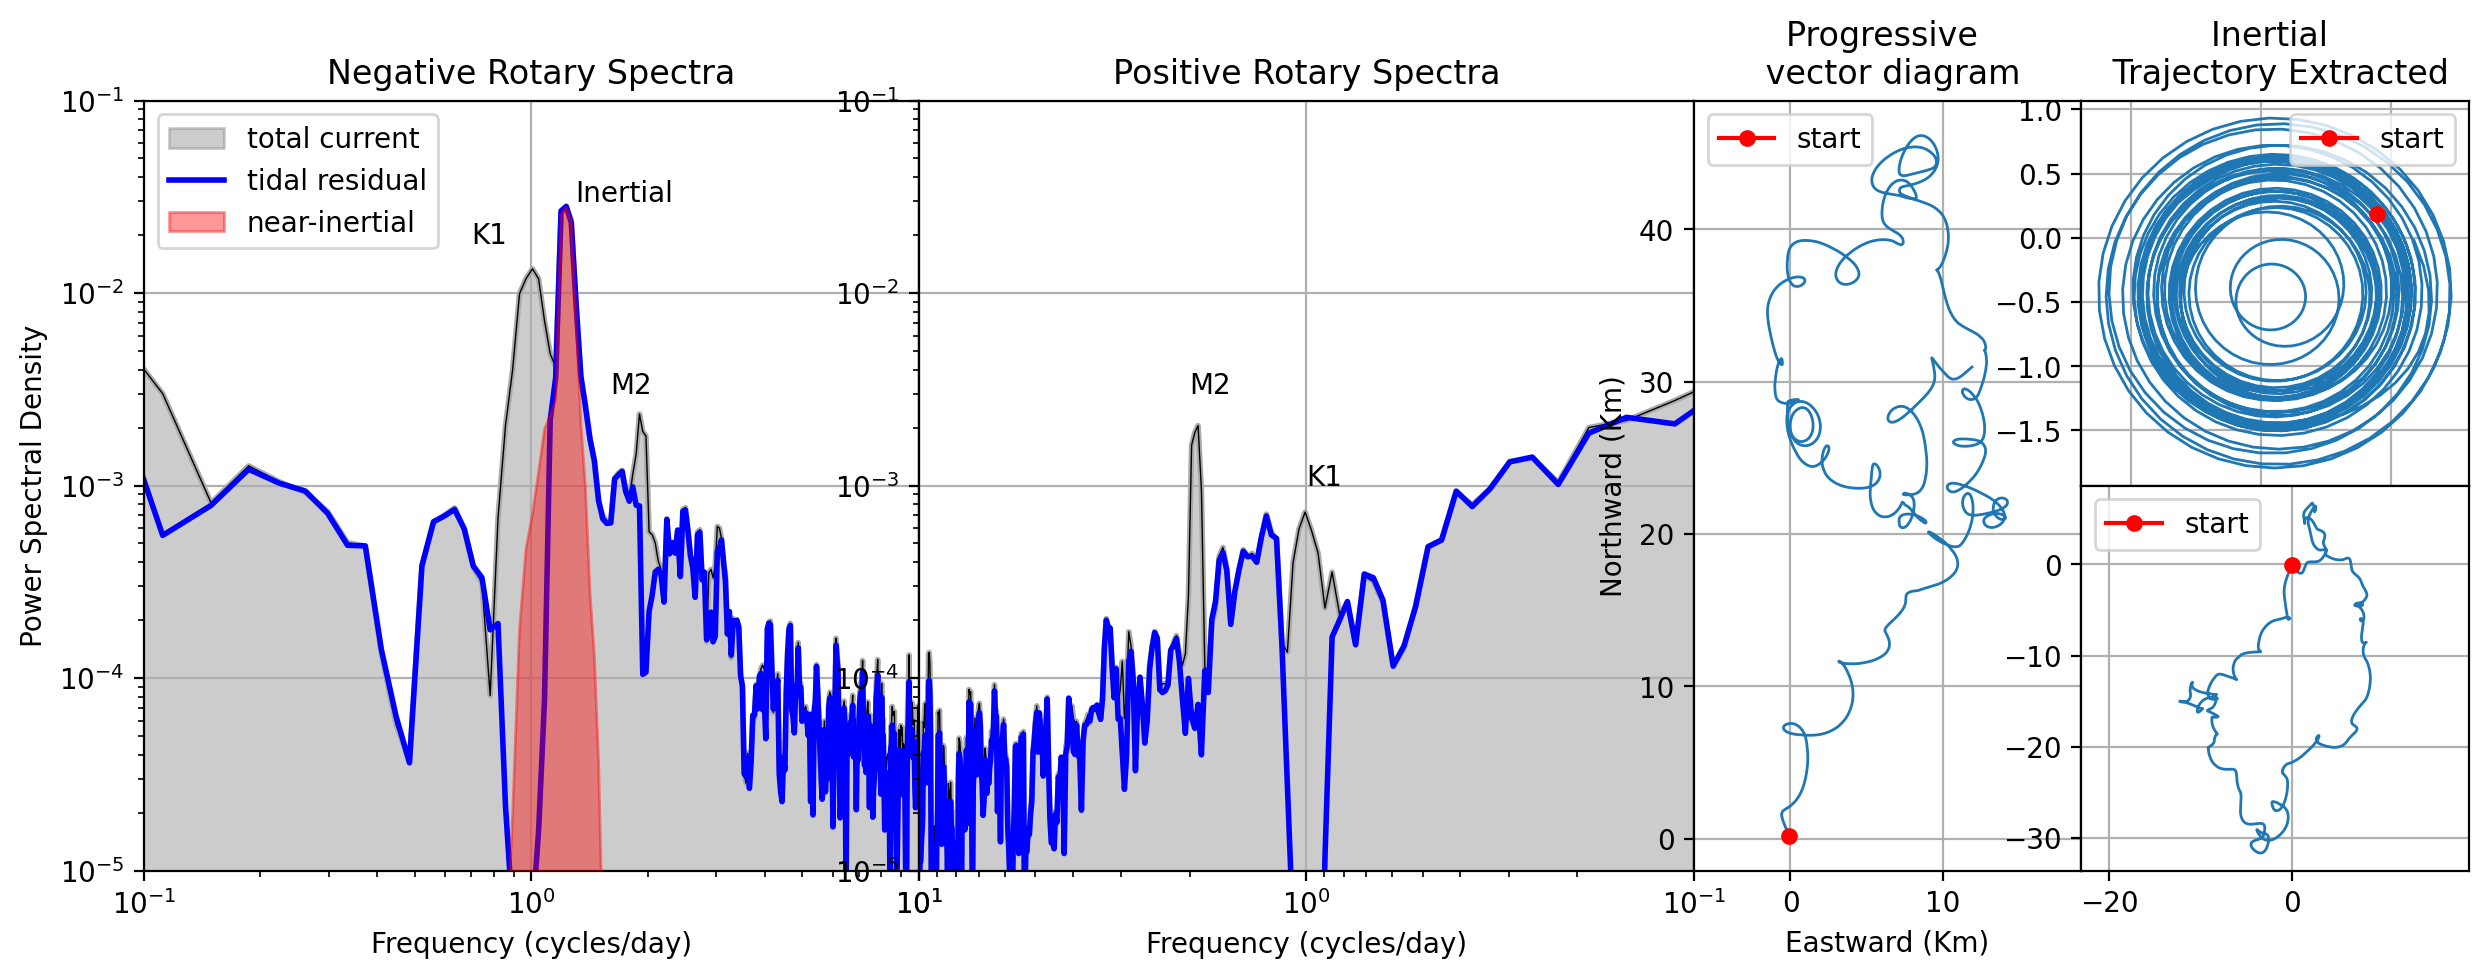

In [20]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 200
pyplot.rcParams['savefig.dpi'] = 200

x = pd.Series(uS[:,19], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,19], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000 
P = 2
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
So = np.ravel(spec.spec)
fo = np.ravel(spec.freq)

cv = savgol_filter(u_baroclinic[:,19],5,2) +1j*savgol_filter(v_baroclinic[:,19],5,2)
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
Sox = np.ravel(spec.spec)
fox = np.ravel(spec.freq)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
mask = fo >= 0
plt.fill_between(fo[mask], So[mask], color="grey", alpha=0.4, label = 'total current')
plt.loglog(fo[fo>0],So[fo>0],linewidth=2,color="#AAAAAA")#plot positive side
plt.loglog(fo[fo>0],So[fo>0],linewidth=0.5,color="k")#plot positive side
mask = f >= 0
#plt.loglog(f[f >= 0], po[np.where(f >= 0)],linewidth=1,color="r")
#plt.fill_between(f[mask], po[mask], color="grey", alpha=0.4)
plt.loglog(fox[fox>0],Sox[fox>0],linewidth=2,color="blue", label = 'tidal residual')#plot positive side
plt.fill_between(f[mask], po[mask], color="red", alpha=0.4, zorder=3, label = 'near-inertial')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power Spectral Density')
plt.title('Negative Rotary Spectra');
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.text(1.3,0.03,'Inertial')
plt.text(0.7,0.018,'K1')
plt.text(1.6,0.003,'M2')
plt.grid()
#plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)
plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1,3,2)
mask = fo<0
plt.fill_between(-fo[mask], So[mask], color="grey", alpha=0.4)
plt.loglog(-fo[fo<0],So[fo<0],linewidth=2,color="#AAAAAA")#plot negative side
plt.loglog(-fo[fo<0],So[fo<0],linewidth=0.5,color="k")#plot negative side
plt.loglog(-fox[fox<0],Sox[fox<0],linewidth=2,color="b")#plot negative side
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Frequency (cycles/day)')
plt.title('Positive Rotary Spectra');
plt.text(1,0.001,'K1')
plt.text(2,0.003,'M2')
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.grid()
#plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)


plt.subplot(1,6,5)
dt = 30*60
xx = np.cumsum(savgol_filter(x,24,2)/1000) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(y,24,2)/1000) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(x_km, y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.legend()
del x, y, x_km, y_km
plt.xlabel('Eastward (Km)')
plt.ylabel('Northward (Km)')
plt.axis('equal')
plt.grid()
plt.title('Progressive \n vector diagram')


plt.subplot(2,6,6)
dt = 30*60
xx = np.cumsum(savgol_filter(cvo_K1NIOSneg.real,24,2)) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(cvo_K1NIOSneg.imag,24,2)) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(x_km, y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.legend()
plt.title('Inertial \n Trajectory Extracted')
plt.grid()

plt.subplot(2,6,12)
dt = 30*60
xx = np.cumsum(savgol_filter(cvr_K1NIOS.real+cvo_K1NIOSpos.real,24,2)) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(cvr_K1NIOS.imag+cvo_K1NIOSpos.imag,24,2)) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(x_km, y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.axis('equal')
plt.legend()
plt.grid()



Text(0.5, 1.0, 'Negative Freq')

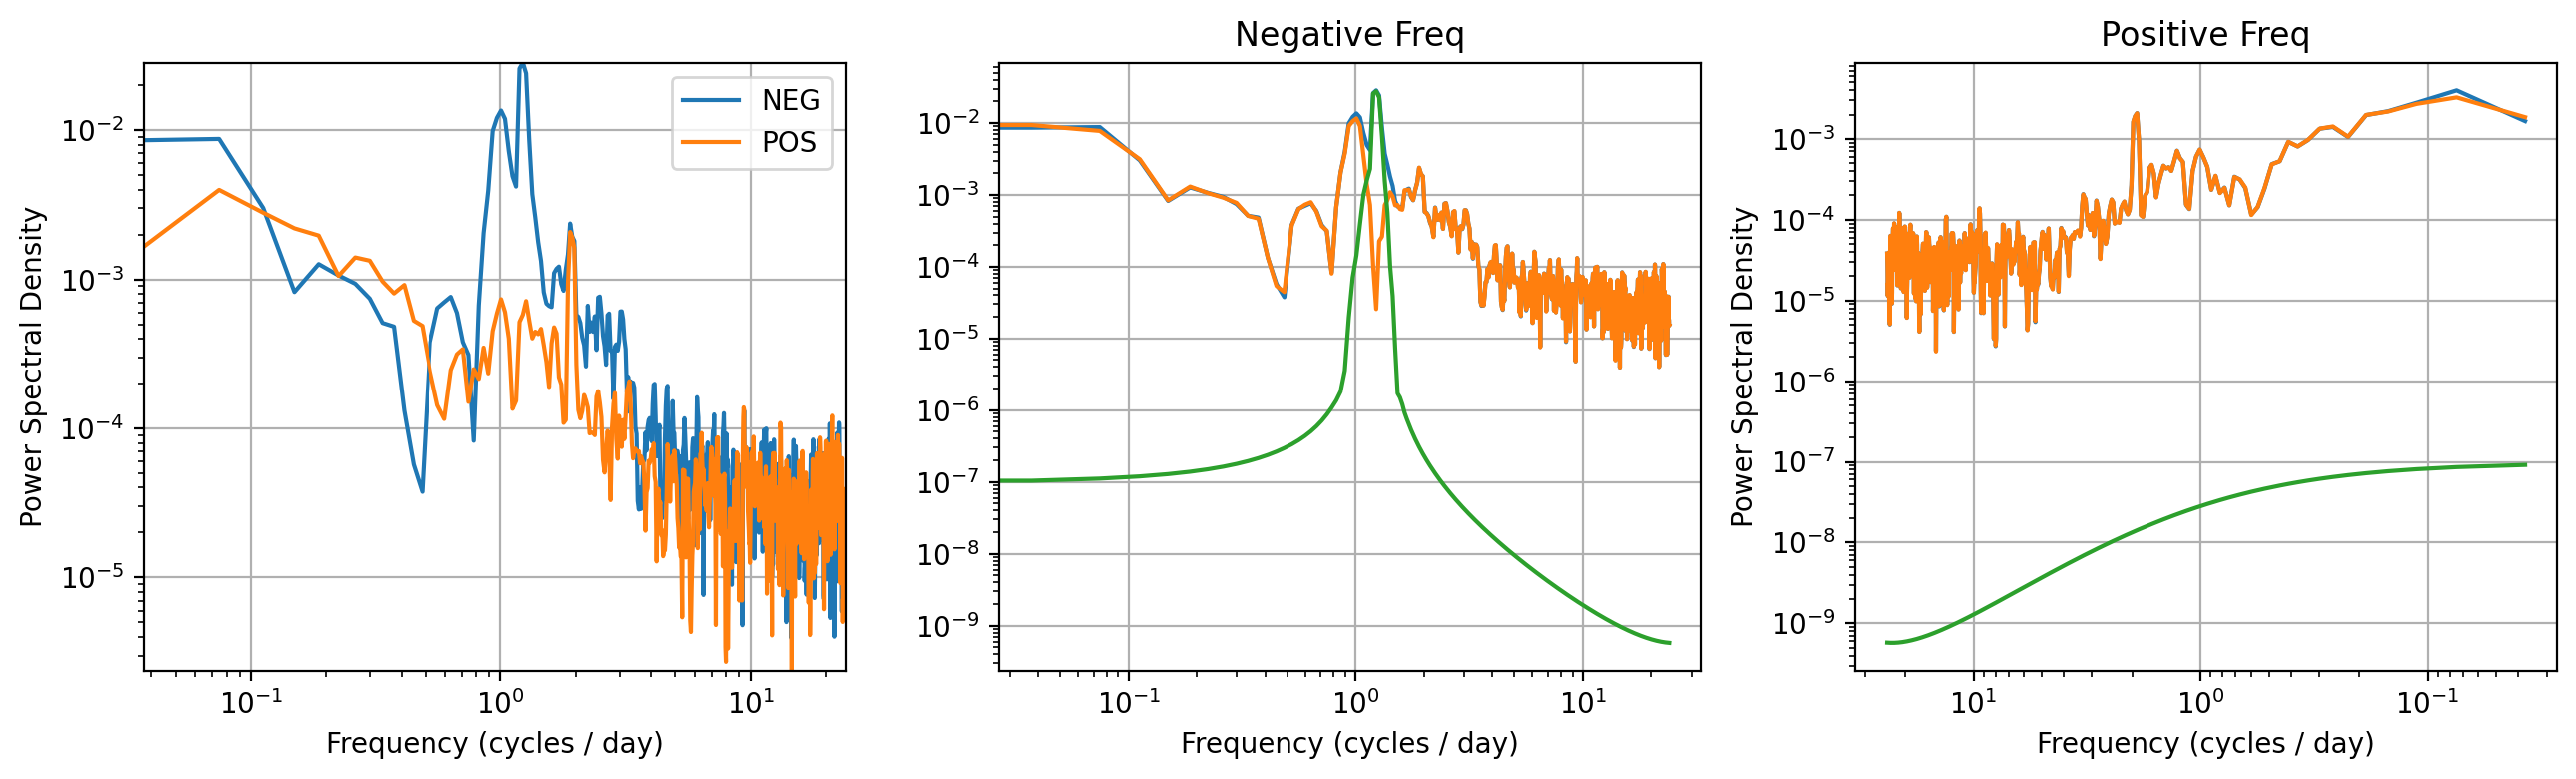

In [21]:
x = pd.Series(uS[:,19], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,19], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000
cv_centered = cv - np.mean(cv)
f, p = signal.periodogram(cv_centered, fs=1/dt, return_onesided=False, axis=0)

NW = 2
Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cv_centered, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cv_centered))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
p = np.mean(Sk*eigenvalues, axis=1) * dt

plt.figure(figsize=(13, 4))
plt.subplot(1,3,1)
plt.loglog(f[f >= 0], p[np.where(f >= 0)])
plt.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
plt.autoscale(enable=True, tight=True)
plt.tight_layout(), plt.grid()
plt.xlabel("Frequency (cycles / day)")
plt.ylabel("Power Spectral Density")
plt.legend(['NEG','POS'])
plt.tight_layout()

#---------------------------------------------

gamma = 3
beta = 50
omega=2*np.pi*33/len(cv_centered)

morse = analytic_wavelet.GeneralizedMorseWavelet(gamma, beta)
psi, psif = morse.make_wavelet(len(cv_centered), omega)

#compute two bandpassed signals, one for the negative side and one for the positive side
cvo_K1NIOSneg = analytic_wavelet.analytic_wavelet_transform(cv_centered, psif, False).flatten() #NEGATIVE BAND
cvo_K1NIOSpos = np.conj(analytic_wavelet.analytic_wavelet_transform(np.conj(cv_centered), psif, False)).flatten() #POSITIVE BAND
cvo_K1NIOS = 1/np.sqrt(2)*(cvo_K1NIOSneg)# + cvo_K1NIOSpos)
cvr_K1NIOS = cvo_K1NIOS  - cv

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvo_K1NIOS, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvo_K1NIOS))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
po = np.mean(Sk*eigenvalues, axis=1) * dt

Sk_complex, weights, eigenvalues = spectrum.mtm.pmtm(cvr_K1NIOS, NW=NW, k=2*NW-1, method="adapt", NFFT=len(cvr_K1NIOS))
Sk = np.abs(Sk_complex)**2
Sk = Sk.T
pr = np.mean(Sk*eigenvalues, axis=1) * dt

plt.subplot(1,3,3)
plt.loglog(np.abs(f[f < 0]), p[np.where(f < 0)])
plt.loglog(np.abs(f[f < 0]), pr[np.where(f < 0)])
plt.loglog(np.abs(f[f < 0]), po[np.where(f < 0)])
plt.xlabel("Frequency (cycles / day)")
plt.ylabel("Power Spectral Density")
plt.title('Positive Freq')
plt.tight_layout()
plt.gca().invert_xaxis(), plt.grid()

plt.subplot(1,3,2)
plt.loglog(f[f >= 0], p[np.where(f >= 0)])
plt.loglog(f[f >= 0], pr[np.where(f >= 0)])
plt.loglog(f[f >= 0], po[np.where(f >= 0)])
plt.tight_layout(), plt.grid()
plt.xlabel("Frequency (cycles / day)")
plt.title('Negative Freq')

Text(0, 0.5, 'Km')

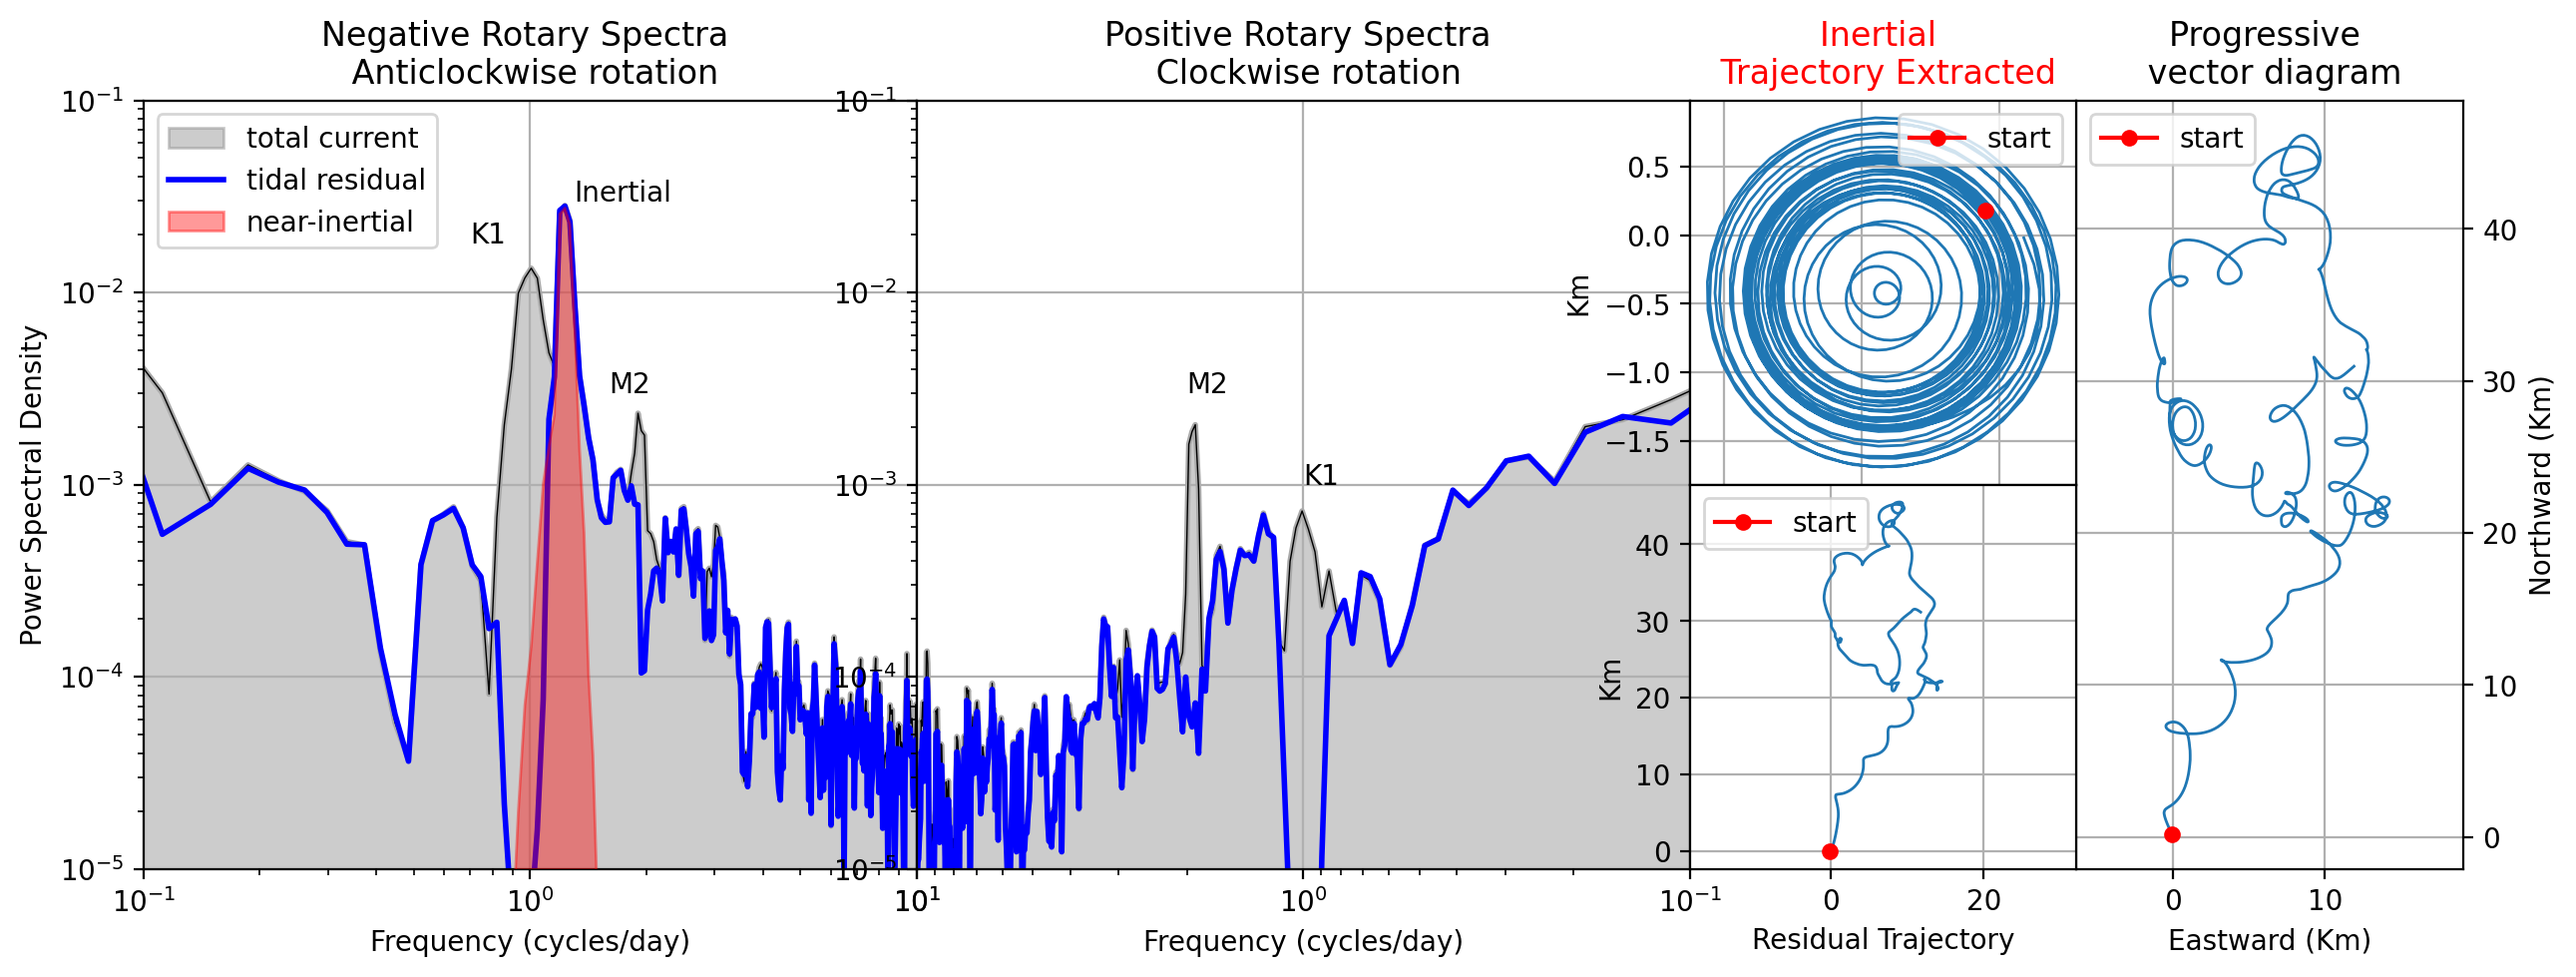

In [22]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 200
pyplot.rcParams['savefig.dpi'] = 200

x = pd.Series(uS[:,19], index=timeX['datetime'])
x = x.interpolate(method="time")
x = x.values

y = pd.Series(vS[:,19], index=timeX['datetime'])
y = y.interpolate(method="time")
y = y.values

dt = 0.5/24
cv = x/1000 +1j*y/1000 
P = 2
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
So = np.ravel(spec.spec)
fo = np.ravel(spec.freq)

cv = savgol_filter(u_baroclinic[:,19],5,2) +1j*savgol_filter(v_baroclinic[:,19],5,2)
spec = MTSpec(cv-np.mean(cv), nw=P, dt=dt, iadapt=1, nfft=len(cv))
Sox = np.ravel(spec.spec)
fox = np.ravel(spec.freq)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
mask = fo >= 0
plt.fill_between(fo[mask], So[mask], color="grey", alpha=0.4, label = 'total current')
plt.loglog(fo[fo>0],So[fo>0],linewidth=2,color="#AAAAAA")#plot positive side
plt.loglog(fo[fo>0],So[fo>0],linewidth=0.5,color="k")#plot positive side
mask = f >= 0
#plt.loglog(f[f >= 0], po[np.where(f >= 0)],linewidth=1,color="r")
#plt.fill_between(f[mask], po[mask], color="grey", alpha=0.4)
plt.loglog(fox[fox>0],Sox[fox>0],linewidth=2,color="blue", label = 'tidal residual')#plot positive side
plt.fill_between(f[mask], po[mask], color="red", alpha=0.4, zorder=3, label = 'near-inertial')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power Spectral Density')
plt.title('Negative Rotary Spectra \n Anticlockwise rotation');
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.text(1.3,0.03,'Inertial')
plt.text(0.7,0.018,'K1')
plt.text(1.6,0.003,'M2')
plt.grid()
#plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)
plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1,3,2)
mask = fo<0
plt.fill_between(-fo[mask], So[mask], color="grey", alpha=0.4)
plt.loglog(-fo[fo<0],So[fo<0],linewidth=2,color="#AAAAAA")#plot negative side
plt.loglog(-fo[fo<0],So[fo<0],linewidth=0.5,color="k")#plot negative side
plt.loglog(-fox[fox<0],Sox[fox<0],linewidth=2,color="b")#plot negative side
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Frequency (cycles/day)')
plt.title('Positive Rotary Spectra \n Clockwise rotation');
plt.text(1,0.001,'K1')
plt.text(2,0.003,'M2')
plt.ylim([10e-6, 10e-2])
plt.xlim([10e0, 10e-2])
plt.grid()
#plt.axhline(0.01, linestyle = '--', color = 'r', linewidth = 0.8)


plt.subplot(1,6,6)
dt = 30*60
xx = np.cumsum(savgol_filter(x,24,2)/1000) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(y,24,2)/1000) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(x_km, y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.legend()
del x, y, x_km, y_km
plt.xlabel('Eastward (Km)')
plt.ylabel('Northward (Km)')
plt.grid()
plt.title('Progressive \n vector diagram')
plt.axis('equal')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

plt.subplot(2,6,5)
dt = 30*60
xx = np.cumsum(savgol_filter(cvo_K1NIOSneg.real,24,2)) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(cvo_K1NIOSneg.imag,24,2)) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(x_km, y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.legend()
plt.title('Inertial \n Trajectory Extracted', color = 'r')
plt.grid()
plt.ylabel('Km')

plt.subplot(2,6,11)
dt = 30*60
xx = np.cumsum(savgol_filter(cvr_K1NIOS.real+cvo_K1NIOSpos.real,24*2,2)) * dt  # Eastward displacement (m)
yx = np.cumsum(savgol_filter(cvr_K1NIOS.imag+cvo_K1NIOSpos.imag,24*2,2)) * dt  # Northward displacement (m)
x_km = xx / 1000  
y_km = yx / 1000 
plt.plot(-x_km, -y_km, linewidth=1)
plt.plot(x_km[0], y_km[0] , marker = '.', color = 'r', markersize = 10, label = 'start')
plt.axis('equal')
plt.legend()
plt.grid()
plt.xlabel('Residual Trajectory')
plt.ylabel('Km')